In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import r2_score, make_scorer, mean_squared_error
from scipy.stats import randint as sp_randint
from scikeras.wrappers import KerasRegressor

# Explore Data

In [5]:
admissions_data = pd.read_csv("admissions_data.csv")
admissions_data.head()

In [6]:
admissions_data.describe()

In [7]:
print(admissions_data.shape)

In [8]:
features = admissions_data.iloc[:,1:8] 
labels = admissions_data.iloc[:,-1]
print(features, labels)

# Preprocess Data

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
sc = StandardScaler()
features_train_scaled = sc.fit_transform(features_train)
features_test_scaled = sc.transform(features_test)

In [11]:
# Base Linear Regression Model
reg = LinearRegression().fit(features_train_scaled, labels_train)
reg.score(features_train_scaled, labels_train)
y_pred_reg = reg.predict(features_test_scaled)
print("R_sq: ", r2_score(labels_test, y_pred_reg))
print("MSE: ", mean_squared_error(labels_test, y_pred_reg))

R_sq:  0.8188432567829629
MSE:  0.003704655398788409


# First Model

In [13]:
# Model 1
def model_1():
    model = Sequential([
        tf.keras.Input(shape=(7,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

model1 = model_1()

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

# Train Model1
model1.fit(features_train_scaled, labels_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.2415 - val_accuracy: 0.0000e+00 - val_loss: 0.2507
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.2000 - val_accuracy: 0.0000e+00 - val_loss: 0.2200
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.1625 - val_accuracy: 0.0000e+00 - val_loss: 0.1732
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.1136 - val_accuracy: 0.0000e+00 - val_loss: 0.1324
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0956 - val_accuracy: 0.0000e+00 - val_loss: 0.1056
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0816 - val_accuracy: 0.0000e+00 - val_loss: 0.0871
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0691 - val_accuracy: 0.0000e+00 - val_loss: 0.0723
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

In [14]:
# Evaluate Model 1 with test data
val_mse = model1.evaluate(features_test_scaled, labels_test, verbose=0)
y_pred = model1.predict(features_test_scaled)
print("R_sq: ", r2_score(labels_test,y_pred))
print("MSE: ", val_mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R_sq:  0.613282852325409
MSE:  [0.007908365689218044, 0.0]


R-squared and MSE are very underfitting, meaning the model is too simple and hasn't learned enough :( 
Use randomized search to adjust hyperparameter and increase model complexity using layers or neurons

# Randomized Search

In [17]:
keras_regressor = KerasRegressor(model=model_1, verbose=0)

param_grid = {
    'batch_size': sp_randint(8, 32), 
    'epochs': sp_randint(10, 150)}

random_search = RandomizedSearchCV(
    estimator=keras_regressor,
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1)

random_search.fit(features_train_scaled, labels_train, callbacks=[es])

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'batch_size': 9, 'epochs': 78}


# Adjusted Model

In [46]:
# Model 2
def model_2():
    model = Sequential([
        tf.keras.Input(shape=(7,)),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

model2=model_2()

history = model2.fit(features_train_scaled, labels_train, epochs=78, batch_size=9, validation_split=0.2, callbacks=[es])

Epoch 1/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.6208 - val_accuracy: 0.0000e+00 - val_loss: 0.1530
Epoch 2/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.2416 - val_accuracy: 0.0000e+00 - val_loss: 0.1014
Epoch 3/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.1959 - val_accuracy: 0.0000e+00 - val_loss: 0.0670
Epoch 4/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.1181 - val_accuracy: 0.0000e+00 - val_loss: 0.0484
Epoch 5/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.1080 - val_accuracy: 0.0000e+00 - val_loss: 0.0370
Epoch 6/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.1207 - val_accuracy: 0.0000e+00 - val_loss: 0.0246
Epoch 7/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0741 - val_accuracy: 0.0000e+00 - val_loss: 0.0230
Epoch 8/78
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

In [48]:
# Evaluate Model2 with test data
val_mse = model2.evaluate(features_test_scaled, labels_test, verbose=0)
y_pred = model2.predict(features_test_scaled)
print("R_sq: ", r2_score(labels_test,y_pred))
print("MSE: ", val_mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
R_sq:  0.8065736617744088
MSE:  [0.003955568186938763, 0.0]


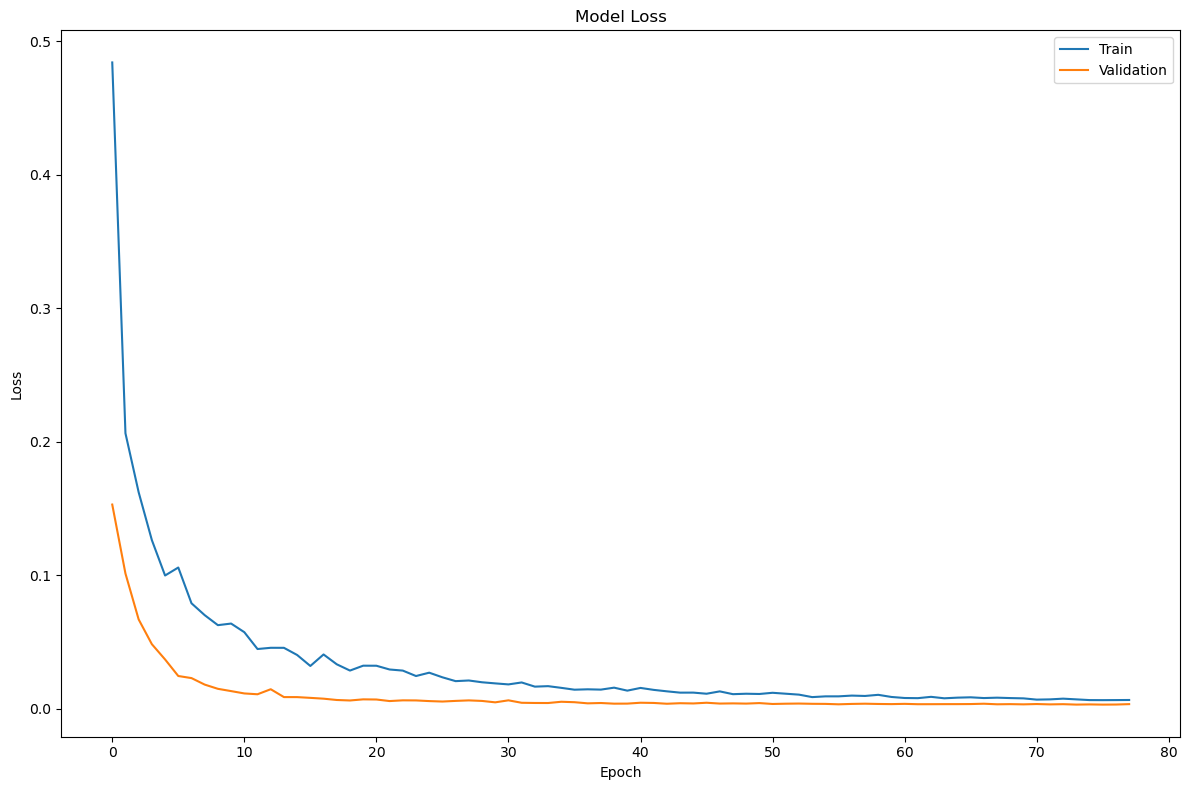

In [50]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

After adjusting the parameter based on random search, model generalizes better with higher R-sq and lower Mean-sq!🙆‍♀️